In [73]:
# Single wheel and damper assembly

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi

from utils import *

In [74]:
# Main body parameters
sc_mass = 200 # kg
sc_I = np.array([[350, 0, 0], [0, 300, 0], [0, 0, 400]]) # kg m^2



sc_Sp = np.array([[0],[0],[0]]) # Static moment of main body

In [75]:
# Wheel parameters
wheel_mass = 20 # kg
wheel_radius = 1 # m
wheel_distance = np.array([[0], [0], [0]]) # m distance from the center of mass of the main body

wheel_Is = wheel_mass * wheel_radius**2 / 2 # kg m^2
wheel_It = wheel_mass * wheel_radius**2 / 4 # kg m^2

Jww_B= np.array([[wheel_Is, 0, 0], [0, wheel_It, 0], [0, 0, wheel_It]]) # kg m^2 # Inertia tensor of the wheel in body frame
# state variables are om_s, om_s_dot = control input

w_axis = np.array([[1], [0], [0]]) # axis of rotation of the wheel
w_Sp = wheel_mass*wheel_distance # Static moment of the wheel
wheel_locked = False

In [76]:
# Damper parameters
md = 1 # kg
Kd = 1 # Kg/s^2
Cd = 5 # Kg/s
b = np.array([[0], [0], [2]]) # m distance from the center of mass of the main body
d_axis = np.array([[1], [0],[ 0]]) # damper axis

# State variables are chi, chi_dot
d_Sp = md*b # Static moment of damper, assuming chi0 = 0


In [77]:
# External forces
Fext = np.array([[0],[ 0], [0]]) # N
Mext = np.array([[0], [0], [0]]) # Nm

In [78]:
### System matrix definition
def reset_Mt():
    global Mt
    Mt = np.zeros((8,8))

    M = sc_mass + wheel_mass + md
    Sp0 = skew(sc_Sp + w_Sp + d_Sp)
    Jp0 = sc_I + Jww_B + md*(b@b.T*np.eye(3) - np.outer(b,b)) # Inertia tensor of the system
    ## Mass equations

    Mt[0:3, 0:3] = M * np.eye(3) # Total mass of the system
    Mt[0:3, 3:6] = -Sp0
    # omega
    Mt[3:6, 0:3] = Sp0
    Mt[3:6, 3:6] = Jp0
    ## Damper equations
    # vP
    Mt[6, 6] = md
    Mt[0:3, 6:7] = md * d_axis
    Mt[6:7, 0:3] = md * np.transpose(d_axis)
    # omega
    Mt[3:6, 6:7] = md*skew(b)@d_axis
    Mt[6:7, 3:6] = -md*np.transpose(d_axis)@skew(b)

    ## Wheel equations
    Mt[7, 7] = wheel_Is
    # omega
    Mt[3:6, 7:8] = wheel_Is*w_axis
    Mt[7:8, 3:6] = wheel_Is*np.transpose(w_axis)
    return Mt




def update_Mt(Mt_, rd: np.ndarray):
    
    Sp = skew(sc_Sp + w_Sp + md*rd)
    Jp = sc_I + Jww_B + md*(rd@rd.T*np.eye(3,3) - np.outer(rd,rd))
    Mt[0:3, 3:6] = -Sp
    # omega
    Mt[3:6, 0:3] = Sp
    Mt[3:6, 3:6] = Jp

    return Mt



In [79]:
### Simulation with no control, integrating xi = [PP, Hp, Pn, ha, chi] over time
ga_control = lambda t, y: 0

def simulate(t, y: np.ndarray):
    global Mt
    global nu_array # store nu values for plotting
    global ga_control
    # Unpack state variables

    # Take y and make it a 9x1 vector
    y = y.reshape(9,1)  
    PP = y[0:3,0:1] 
    Hp = y[3:6, 0:1]
    Pn = y[6][0]
    
    ha = y[7][0]
    chi = y[8][0]

    
    
    
    # Update mass matrix
    rd = b + chi*d_axis
    Mt = update_Mt(Mt, rd)

    nu = np.linalg.inv(Mt)@np.vstack((PP, Hp, Pn, ha))
    nu_array = np.hstack((nu_array, nu))

    vP = nu[0:3, 0:1] 
    om = nu[3:6, 0:1]
    chi_dot = nu[6]  
    om_s = nu[7]

    dy = np.zeros((9,1))

    dy[0:3, 0:1] = -skew(om)@PP# PPdot
    dy[3:6, 0:1] = -skew(vP)@PP -skew(om)@Hp # HPdot
    dy[6] = md*np.transpose(om)@skew(d_axis)@(vP - skew(rd)@om) - Kd*chi - Cd*chi_dot # Pndot
    
    
    dy[7] = ga_control(t, y) # hadot
    dy[8] = chi_dot # chidot
    
    return dy.flatten()

In [80]:
### Simulation with no control, integrating nu = [vP, om, chi_dot, om_s, chi] over time
ga_control = lambda t, y: 0
def simulate_nu(t, nu: np.ndarray):
    global Mt, Mt_dot
    
    nu = nu.reshape((9,1))
    # Unpack state variables
    vP = nu[0:3, 0:1]
    om = nu[3:6, 0:1]
    chi_dot = nu[6][0]
    om_s = nu[7][0]
    chi = nu[8][0]

    _nu = nu[0:8] # exclude chi

    # Update mass matrix
    rd = b + chi*d_axis
    Mt = update_Mt(Mt, rd)

    ### Compute system matrix derivative Mt_dot
 
    S_dot = skew(md*chi_dot*d_axis)
    b_norm = np.linalg.norm(b)
    I_dot = md*np.array([[0, 0, -chi_dot*b_norm], [0, 2*chi*chi_dot, 0], [-chi_dot*b_norm, 0, 2*chi*chi_dot]])    
    # Sp_dot
    Mt_dot[0:3, 3:6] = -S_dot
    Mt_dot[3:6, 0:3] = S_dot
    # Jp_dot
    Mt_dot[3:6, 3:6] = I_dot

    

    ## Build nu_dot = inv(Mt-B)@((A@Mt - Mt_dot)@om - c)
    # A
    A = np.zeros((8,8))
    A[0:3, 0:3] = -skew(om)
    A[3:6, 0:3] = -skew(vP)
    A[3:6, 3:6] = -skew(om)

    # B
    B = np.zeros((8,8))
    
    # if a wheel is locked, update B
    if wheel_locked:
        B[7:8, 3:6] = wheel_Is*w_axis.T
    
    # c 
    c = np.zeros((8,1))
    c[0:3,0:1] = Fext
    c[3:6, 0:1] = Mext
    c[6:7, 0:1] = md*np.transpose(om)@skew(d_axis)@(vP - skew(rd)@om) - Kd*chi - Cd*chi_dot

    if wheel_locked:
        # if wheel is locked, B absorbs the control input
        c[7] = 0
    else:
        c[7] = ga_control(t, nu)
        
    
    nu_dot = np.zeros((9,1))
    # Compute nu_dot (without chi augmentation)
    nu_dot[0:8, 0:1] = np.linalg.inv(Mt-B)@( ( A@Mt - Mt_dot )@_nu + c )
    # Augment nu_dot with chi_dot
    nu_dot[8:9,0:1] = chi_dot
    
    return nu_dot.flatten()




In [81]:
# # Set up the simulation
t0 = 0
tf = 3600 # s

In [82]:

Mt = reset_Mt()
Mt_dot = np.zeros((8,8))

nu0 = np.array([0, 0, 0, 0.2*np.pi, 0.05, 0.05, 0, 0]) # Initial conditions for [PP, HP, Pn, ha, chi]
nu0_aug = np.hstack((nu0, 0)) # Augment nu0 with chi
# Wheel locked
wheel_locked = True

nu_solver = spi.solve_ivp(simulate_nu, (t0, tf), nu0_aug, method='RK45', t_eval=np.linspace(t0, tf, tf-t0)) # Runge-Kutta 4th/5th order, 1s step



In [83]:
Mt = reset_Mt()
nu0 = np.array([ 0, 0, 0, 0.2*np.pi, 0.05, 0.05, 0, 0]) # Initial conditions for [PP, HP, Pn, ha]
nu0_aug = np.hstack((nu0, 0)) # Augment nu0 with chi
nu_array = np.array(nu0.reshape(8,1)) # store nu values for plotting
y0 = Mt@nu0 # Le condizioni iniziali sono su [PP, HP, Pn, ha]
# Add chi0 to the initial conditions
y0 = np.hstack((y0, 0))
solver = spi.solve_ivp(simulate, (t0, tf), y0, method='RK45', t_eval=np.linspace(t0, tf, tf-t0)) # Runge-Kutta 4th/5th order, 1s step

Text(0.5, 1.0, 'Angular velocity of the system')

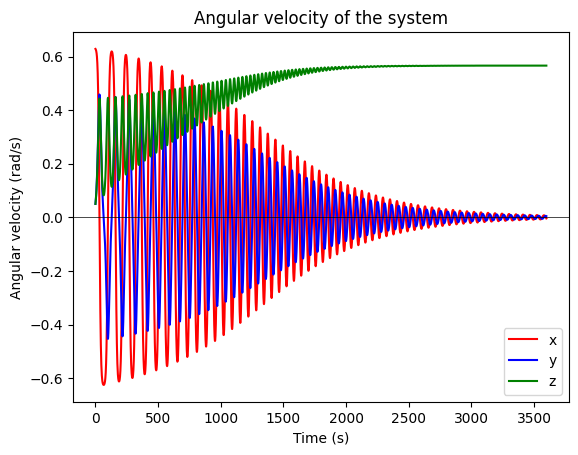

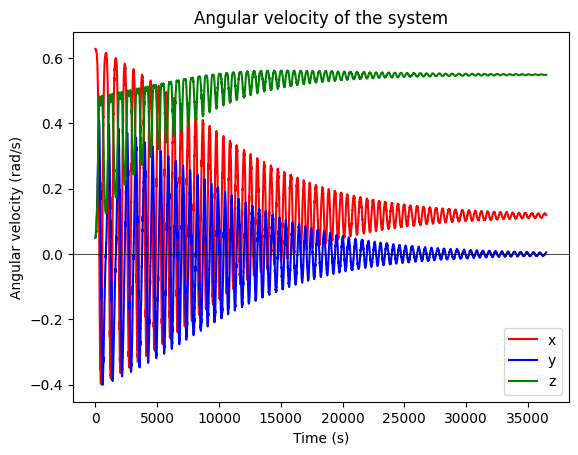

In [84]:
om1 = nu_solver.y[3:6,:]
om2 = nu_array[3:6,:]
plt.figure()

plt.plot(om1[0,:], label='x', color='red')
plt.plot(om1[1,:], label='y', color = "blue")
plt.plot(om1[2,:], label='z', color = "green")
# Plot horizontal line at 0
plt.axhline(0, color='black', lw=0.5)

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Angular velocity (rad/s)')
plt.title('Angular velocity of the system')

plt.figure()
plt.plot(om2[0,:], label='x', color='red')
plt.plot(om2[1,:], label='y', color = "blue")
plt.plot(om2[2,:], label='z', color = "green")
# Plot horizontal line at 0
plt.axhline(0, color='black', lw=0.5)

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Angular velocity (rad/s)')
plt.title('Angular velocity of the system')

Text(0.5, 0, 'Time (s)')

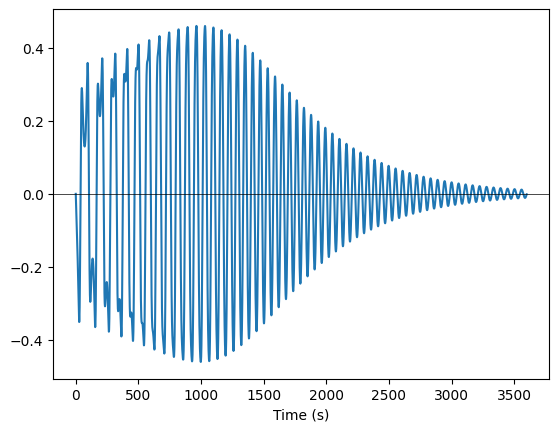

In [85]:
chi = nu_solver.y[8,:]
plt.figure()
plt.plot(chi)
# Plot horizontal line at 0
plt.axhline(0, color='black', lw=0.5)

plt.xlabel('Time (s)')



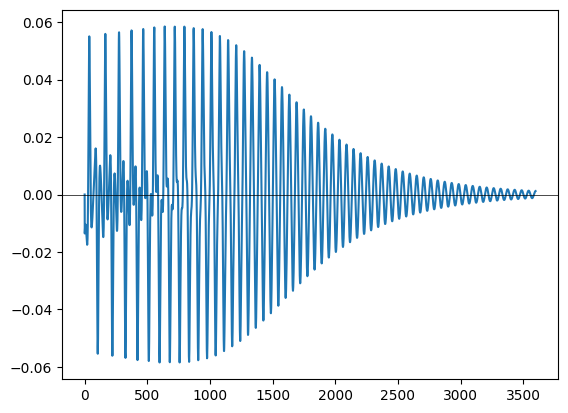

In [86]:
chi_dot = nu_solver.y[6,:]
plt.figure()
plt.plot(chi_dot)
# Plot horizontal line at 0
plt.axhline(0, color='black', lw=0.5)

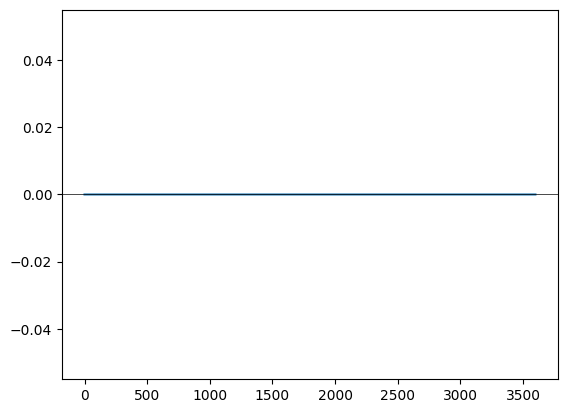

In [87]:
om_s =  nu_solver.y[7,:]
plt.figure()
plt.plot(om_s)
# Plot horizontal line at 0
plt.axhline(0, color='black', lw=0.5)
